<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
## Open Machine Learning Course
<center>Author: [Yury Kashnitsky](https://www.linkedin.com/in/festline/), Data Scientist @ Mail.Ru Group <br>All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #10 (demo)
## <center> Gradient boosting

Your task is to beat at least 2 benchmarks in this [Kaggle Inclass competition](https://www.kaggle.com/c/flight-delays-spring-2018). Here you won’t be provided with detailed instructions. We only give you a brief description of how the second benchmark was achieved using Xgboost. Hopefully, at this stage of the course, it's enough for you to take a quick look at the data in order to understand that this is the type of task where gradient boosting will perform well. Most likely it will be Xgboost, however, we’ve got plenty of categorical features here.

<img src=https://habrastorage.org/webt/fs/42/ms/fs42ms0r7qsoj-da4x7yfntwrbq.jpeg width=40% />

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('input/flight_delays_train.csv')
test = pd.read_csv('input/flight_delays_test.csv')

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Given flight departure time, carrier's code, departure airport, destination location, and flight distance, you have to predict departure delay for more than 15 minutes. As the simplest benchmark, let's take Xgboost classifier and two features that are easiest to take: DepTime and Distance. Such model results in 0.68202 on the LB.

In [5]:
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

We'll train Xgboost with default parameters on part of data and estimate holdout ROC AUC.

In [6]:
xgb_model = XGBClassifier(seed=17)

xgb_model.fit(X_train_part, y_train_part)
xgb_valid_pred = xgb_model.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, xgb_valid_pred)

0.6974401153652741

Now we do the same with the whole training set, make predictions to test set and form a submission file. This is how you beat the first benchmark. 

In [7]:
xgb_model.fit(X_train, y_train)
xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]

pd.Series(xgb_test_pred, 
          name='dep_delayed_15min').to_csv('xgb_2feat.csv', 
                                           index_label='id', header=True)

The second benchmark in the leaderboard was achieved as follows:

- Features `Distance` and `DepTime` were taken unchanged
- A feature `Flight` was created from features `Origin` and `Dest`
- Features `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` and `Flight` were transformed with OHE (`LabelBinarizer`)
- Logistic regression and gradient boosting (xgboost) were trained. Xgboost hyperparameters were tuned via cross-validation. First, the hyperparameters responsible for model complexity were optimized, then the number of trees was fixed at 500 and learning step was tuned.
- Predicted probabilities were made via cross-validation using `cross_val_predict`. A linear mixture of logistic regression and gradient boosting predictions was set in the form $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, where $p_{logit}$ is a probability of class 1, predicted by logistic regression, and $p_{xgb}$ – the same for xgboost. $w_1$ weight was selected manually.
- A similar combination of predictions was made for test set. 

Following the same steps is not mandatory. That’s just a description of how the result was achieved by the author of this assignment. Perhaps you might not want to follow the same steps, and instead, let’s say, add a couple of good features and train a random forest of a thousand trees.

Good luck!

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Month                100000 non-null object
DayofMonth           100000 non-null object
DayOfWeek            100000 non-null object
DepTime              100000 non-null int64
UniqueCarrier        100000 non-null object
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
dep_delayed_15min    100000 non-null object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [9]:
df_train = train.copy()

In [10]:
sc = StandardScaler()

In [11]:
#df_train['Distance'] = 
X_scaled = sc.fit_transform(df_train[['Distance', 'DepTime']])

In [12]:
df_train['Distance'] = X_scaled[:, 0]
df_train['DepTIme'] = X_scaled[:, 1]

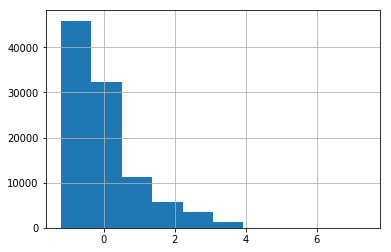

In [13]:
import matplotlib.pyplot as plt
df_train['Distance'].hist()
plt.show()

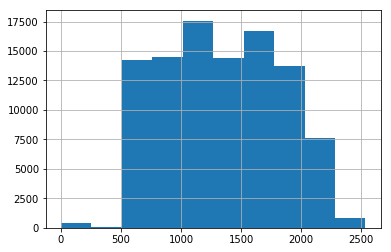

In [14]:
df_train['DepTime'].hist()
plt.show()

In [15]:
df_train['Flight'] = df_train['Origin'] + '-' + df_train['Dest']

In [16]:
from sklearn.preprocessing import LabelBinarizer

In [17]:
lb = LabelBinarizer()

In [19]:
%%time
ohe_labels = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Flight']
for label in ohe_labels:
    out = lb.fit_transform(df_train[label])
    for i in range(out.shape[1]):
        df_train[label + '_' + str(i)] = out[:, i]

Wall time: 13min 24s


In [ ]:
df_train.columns

In [ ]:
drop_columns = ohe_labels

In [29]:
X_train = df_train.values
y_train = df_train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test.values

X_train_part, X_valid, y_train_part, y_valid = \
    train_test_split(X_train, y_train, 
                     test_size=0.3, random_state=17)

MemoryError: Unable to allocate array with shape (4501, 100000) and data type object

In [27]:
lr_2 = LogisticRegression()